### How to use PyTorch LSTMs for time series regression

### Sequence To Sequence 
#### Time-Series Type

- [example Reference 1](https://www.crosstab.io/articles/time-series-pytorch-lstm/) : LSTM TS
- [example Reference 2](https://medium.com/@maxbrenner-ai/implementing-seq2seq-models-for-efficient-time-series-forecasting-88dba1d66187)
 : seq2seq model

 data : 
 - 1) [Cryptojacking Attack Timeseries Dataset](https://www.kaggle.com/datasets/keshanijayasinghe/cryptojacking-attack-timeseries-dataset?select=final-normal-data-set.csv)

- 2) [Benckmark: Anomaly in Timeseries SKAB](https://www.kaggle.com/datasets/caesarlupum/benckmark-anomaly-timeseries-skab)
    - Iurii D. Katser and Vyacheslav O. Kozitsin, “Skoltech Anomaly Benchmark (SKAB).” Kaggle, 2020, doi: 10.34740/KAGGLE/DSV/1693952. 

- 3) [Numenta Anomaly Benchmark (NAB)](https://www.kaggle.com/datasets/boltzmannbrain/nab)
   

In [1]:
import os
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
torch.manual_seed(77)

from torch import nn as nn
from torch.nn import functional as F


In [2]:
# file list check
ad_cause = ['amb_temp', 'cpu', 'ec2', 'mc_temp', 'taxi', 'agkey_hold', 'agkey_updown' ]
watch_dir = './data/NAB/realAWSCloudwatch/realAWSCloudwatch'
anomaly_dir = './data/NAB/realKnownCause/realKnownCause/'
watch_files = [file for file in os.listdir(watch_dir)]
watch_files

['elb_request_count_8c0756.csv',
 'ec2_cpu_utilization_5f5533.csv',
 'ec2_cpu_utilization_ac20cd.csv',
 'ec2_cpu_utilization_825cc2.csv',
 'ec2_cpu_utilization_24ae8d.csv',
 'ec2_disk_write_bytes_c0d644.csv',
 'ec2_disk_write_bytes_1ef3de.csv',
 'ec2_cpu_utilization_fe7f93.csv',
 'ec2_cpu_utilization_c6585a.csv',
 'rds_cpu_utilization_e47b3b.csv',
 'ec2_cpu_utilization_77c1ca.csv',
 'grok_asg_anomaly.csv',
 'ec2_network_in_5abac7.csv',
 'iio_us-east-1_i-a2eb1cd9_NetworkIn.csv',
 'ec2_cpu_utilization_53ea38.csv',
 'rds_cpu_utilization_cc0c53.csv',
 'ec2_network_in_257a54.csv']

In [3]:
# read data
''' aws 클라우드 가상 컴퓨터 ec2의 cpu 사용량 실제 데이터 - 중간에 이상현상이 있음'''

def TSindex (dir, files, i) :
    filepath = os.path.join(watch_dir, watch_files[i])
    print(f"read data : {filepath}")
    df = pd.read_csv(filepath)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index(df['timestamp'])
    df = df.drop('timestamp', axis=1)
    return df

df = TSindex(watch_dir, watch_files, 1)
df

read data : ./data/NAB/realAWSCloudwatch/realAWSCloudwatch/ec2_cpu_utilization_5f5533.csv


,value
timestamp,
2014-02-14 14:27:00,51.846
2014-02-14 14:32:00,44.508
2014-02-14 14:37:00,41.244
2014-02-14 14:42:00,48.568
2014-02-14 14:47:00,46.714
...,...
2014-02-28 14:02:00,38.474
2014-02-28 14:07:00,40.352
2014-02-28 14:12:00,37.912


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4032 entries, 2014-02-14 14:27:00 to 2014-02-28 14:22:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   4032 non-null   float64
dtypes: float64(1)
memory usage: 63.0 KB


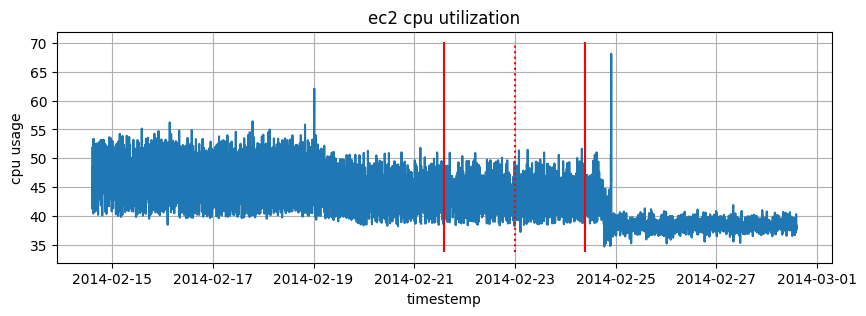

In [5]:
fig, ax = plt.subplots(1,1, figsize=(10,3))
ax.plot(df)
ax.vlines(df[df.index == df.iloc[round(len(df)*0.5)].name].index,
          ymax=(max(df.values)[0]+2), 
          ymin=(min(df.values)[0]-1), colors='red', linestyles= '-')
ax.vlines(df[df.index == df.iloc[round(len(df)*0.6)].name].index,
          ymax=(max(df.values)[0]+2), 
          ymin=(min(df.values)[0]-1), colors='red', linestyles= ':')
ax.vlines(df[df.index == df.iloc[round(len(df)*0.7)].name].index,
          ymax=(max(df.values)[0]+2), 
          ymin=(min(df.values)[0]-1), colors='red', linestyles= '-')
ax.set_title('ec2 cpu utilization')
ax.set_xlabel('timestemp')
ax.set_ylabel('cpu usage')
ax.grid()
fig.tight_layout
plt.show()


##### data split

In [9]:
df_train = df.iloc[:round(len(df)*0.5)]
df_valid = df.iloc[round(len(df)*0.5):round(len(df)*0.6)]
df_test = df.iloc[round(len(df)*0.6):round(len(df)*0.7)]

print(f" df.shape 0.7 : {round(df.shape[0]*0.7)}")
print(f" df_train.shape : {df_train.shape}")
print(f" df_valid.shape : {df_valid.shape}")
print(f" df_test.shape : {df_test.shape}")
print(f" check {(round(df.shape[0]*0.7)) == df_train.shape[0]+df_valid.shape[0]+df_test.shape[0]}")

 df.shape 0.7 : 2822
 df_train.shape : (2016, 1)
 df_valid.shape : (403, 1)
 df_test.shape : (403, 1)
 check True


In [10]:
scaler = StandardScaler()
scaler.fit(df_train)
df_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df.columns)
df_valid_scaled = pd.DataFrame(scaler.transform(df_valid),columns=df.columns)
df_test_scaled = pd.DataFrame(scaler.transform(df_test),columns=df.columns)

In [11]:
scaler.mean_

array([45.51816979])

In [13]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5, predict_length=1):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.predict_length = predict_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()
        self.datetime = dataframe.index 

    def __len__(self):
        return len(self.X) - (self.sequence_length + self.predict_length)
    
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.sequence_length
        seq_x = self.X[s_begin:s_end]
        r_begin = s_end - self.predict_length
        r_end = r_begin + self.predict_length
        seq_y = self.y[r_begin :r_end]
        return seq_x, seq_y

 # start point padding type
    # def __len__(self):
    #     return self.X.shape[0]

    # def __getitem__(self, i): 
    #     if i >= self.sequence_length - 1:
    #         i_start = i - self.sequence_length + 1
    #         x = self.X[i_start:(i + 1), :]
    #     else:
    #         padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
    #         x = self.X[0:(i + 1), :]
    #         x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [14]:
target='value'
features='value'
sequence_length = 12
predict_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length,
    predict_length = predict_length
)

i = 27
X, y = train_dataset[i]
print(X)
print(y)

tensor([50.7740, 46.2620, 43.0520, 50.7180, 45.7980, 46.5500, 48.1220, 40.2300,
        52.6060, 44.6520, 42.8400, 49.2720])
tensor([44.6520, 42.8400, 49.2720])


In [15]:
X, y = train_dataset[i+1]
print(X)
print(y)

tensor([46.2620, 43.0520, 50.7180, 45.7980, 46.5500, 48.1220, 40.2300, 52.6060,
        44.6520, 42.8400, 49.2720, 47.0900])
tensor([42.8400, 49.2720, 47.0900])


In [11]:
print(df_train[features].iloc[i: (i + sequence_length)])

timestamp
2014-02-14 16:42:00    50.774
2014-02-14 16:47:00    46.262
2014-02-14 16:52:00    43.052
2014-02-14 16:57:00    50.718
2014-02-14 17:02:00    45.798
2014-02-14 17:07:00    46.550
2014-02-14 17:12:00    48.122
2014-02-14 17:17:00    40.230
2014-02-14 17:22:00    52.606
2014-02-14 17:27:00    44.652
2014-02-14 17:32:00    42.840
2014-02-14 17:37:00    49.272
Name: value, dtype: float64


In [16]:
def my_collate_fn(batch):
    data = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    # batch_first=True로 설정
    padded_batch = pad_sequence(batch, batch_first=True, padding_value=0) # padding_value는 선택 
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    return padded_batch #, labels_tensor

In [51]:
target='value'
features='value'
batch_size = 30
sequence_length = 12
predict_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length,
    predict_length = predict_length
)
valid_dataset = SequenceDataset(
    df_valid,
    target=target,
    features=features,
    sequence_length=sequence_length,
    predict_length = predict_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length,
    predict_length = predict_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)#, collate_fn=my_collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=True)#, collate_fn=my_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=True)#,collate_fn=my_collate_fn)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([30, 12])
Target shape: torch.Size([30, 3])


In [52]:
X.unsqueeze(2).shape

torch.Size([30, 12, 1])

In [16]:
# valid_loader = DataLoader(valid_dataset, batch_size=30, shuffle=False)

# X,y = next(iter(valid_loader))
# print(X.shape)
# print(X)
# print(y)

# X, y = valid_dataset[391]
# print(X)
# print(y)

### LSTM Model

In [19]:
class LSTM_Layer(nn.Module):
    def __init__(self, 
                 num_features, 
                 hidden_units,
                 predict_length, 
                 bias=True, 
                 num_layers=3, 
                 drop_ratio=0.0,
                 bi_dir=False,
                 device='cpu'):
        super().__init__()
        self.num_features = num_features  # feature's = 현재 1
        self.hidden_units = hidden_units
        self.bias = bias
        self.num_layers = num_layers
        self.drop_ratio = drop_ratio
        self.bi_dir = bi_dir
        self.device = device

        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_units,
            bias=bias,
            batch_first=True,
            num_layers=self.num_layers,
            dropout=drop_ratio,
            bidirectional=bi_dir
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=predict_length, bias=bias)

    def forward(self, x):
        # print(f"x.shape-ori: {x.shape}")
        x = x.unsqueeze(2)
        # print(f"x.shape-unsqz : {x.shape}")
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_().to(self.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_().to(self.device)
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0])  

        return out

In [53]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"is_available device : {device}")

learning_rate = 0.003
num_hidden_units = 124
epochs = 30

model = LSTM_Layer(num_features=len([features]), hidden_units=num_hidden_units, predict_length=predict_length, device=device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


is_available device : cuda


In [54]:
def train_model(data_loader, model, loss_function, optimizer, device):
    num_batches = len(data_loader)
    total_loss = 0
    model.to(device)
    
    model.train()
    for i, (X, y) in enumerate(data_loader):
        X = X.to(device)
        y = y.to(device)
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def eval_model(data_loader, model, loss_function, device=device):
    num_batches = len(data_loader)
    total_loss = 0
    
    model.to(device)

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)
            output = model(X)
            # print(f"input x : {X.shape}")
            # print(f"label y : {y.shape}")
            # print(f"output : {output.shape}")
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"eval loss: {avg_loss}")
    return avg_loss


def infer_model(data_loader, model, device=device):
    num_batches = len(data_loader)
    total_loss = 0
    predict = []
    label = []
    model.to(device)

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)
            output = model(X)
            pred = output.to('cpu').numpy()
            np.squeeze(pred)
            predict.append(list(pred[0]))
            true = y.to('cpu').numpy()
            np.squeeze(true)
            label.append(list(true[0]))
        
    return predict, label


In [55]:
print("Untrained evaluate\n--------")
eval_model(test_loader, model, loss_function, device=device)
print()

epoch = []
train_loss_list = []
eval_loss_list = []

for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer, device=device)
    eval_loss = eval_model(valid_loader, model, loss_function, device=device)
    print()
    epoch.append(ix_epoch+1)
    train_loss_list.append(train_loss)
    eval_loss_list.append(eval_loss)
result = pd.DataFrame({'epoch':epoch, 'train_loss':train_loss_list, 'eval':eval_loss_list})
result


Untrained evaluate
--------
eval loss: 1902.9507735734132

Epoch 0
---------
Train loss: 1216.3034196333451
eval loss: 446.52917226155597

Epoch 1
---------
Train loss: 261.23189706513375
eval loss: 53.25468381245931

Epoch 2
---------
Train loss: 41.69063477082686
eval loss: 8.042039513587952

Epoch 3
---------
Train loss: 14.705708142482873
eval loss: 11.405497709910074

Epoch 4
---------
Train loss: 13.981095906459924
eval loss: 11.893981059392294

Epoch 5
---------
Train loss: 13.966189312212395
eval loss: 11.960952838261923

Epoch 6
---------
Train loss: 13.9538435791478
eval loss: 11.95069440205892

Epoch 7
---------
Train loss: 13.933286493474787
eval loss: 11.955890973409018

Epoch 8
---------
Train loss: 13.979495424212832
eval loss: 11.942107756932577

Epoch 9
---------
Train loss: 13.955542824485086
eval loss: 12.001853148142496

Epoch 10
---------
Train loss: 13.864964990904838
eval loss: 11.886581500371298

Epoch 11
---------
Train loss: 13.612209724657463
eval loss: 11.55

,epoch,train_loss,eval
0,1,1216.303420,446.529172
1,2,261.231897,53.254684
2,3,41.690635,8.042040
3,4,14.705708,11.405498
4,5,13.981096,11.893981
5,6,13.966189,11.960953
6,7,13.953844,11.950694
7,8,13.933286,11.955891
8,9,13.979495,11.942108
9,10,13.955543,12.001853


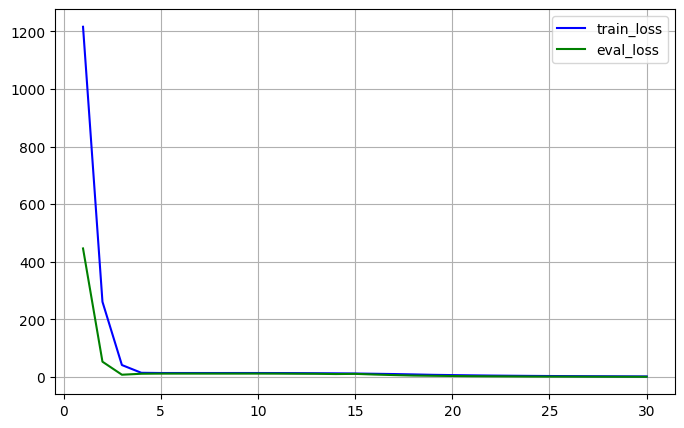

In [56]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(result['epoch'],result['train_loss'], color='blue', label='train_loss')
ax.plot(result['epoch'],result['eval'], color='green', label='eval_loss')
ax.legend()
ax.grid()
plt.show()

In [57]:
predict, trues = infer_model(test_loader, model=model, device=device)


In [58]:
predict = np.array(predict).squeeze()
trues = np.array(trues).squeeze()
infer_result = pd.DataFrame({'predict': predict, 'trues': trues}, index=test_dataset.datetime[13:])



ValueError: Data must be 1-dimensional, got ndarray of shape (388, 3) instead

In [49]:
infer_result

,predict,trues
timestamp,,
2014-02-23 01:07:00,45.626999,45.612000
2014-02-23 01:12:00,39.830044,39.324001
2014-02-23 01:17:00,49.152779,48.731998
2014-02-23 01:22:00,43.241199,43.175999
2014-02-23 01:27:00,43.326836,43.312000
...,...,...
2014-02-24 09:12:00,43.566139,43.661999
2014-02-24 09:17:00,41.468262,41.501999
2014-02-24 09:22:00,46.931103,46.759998


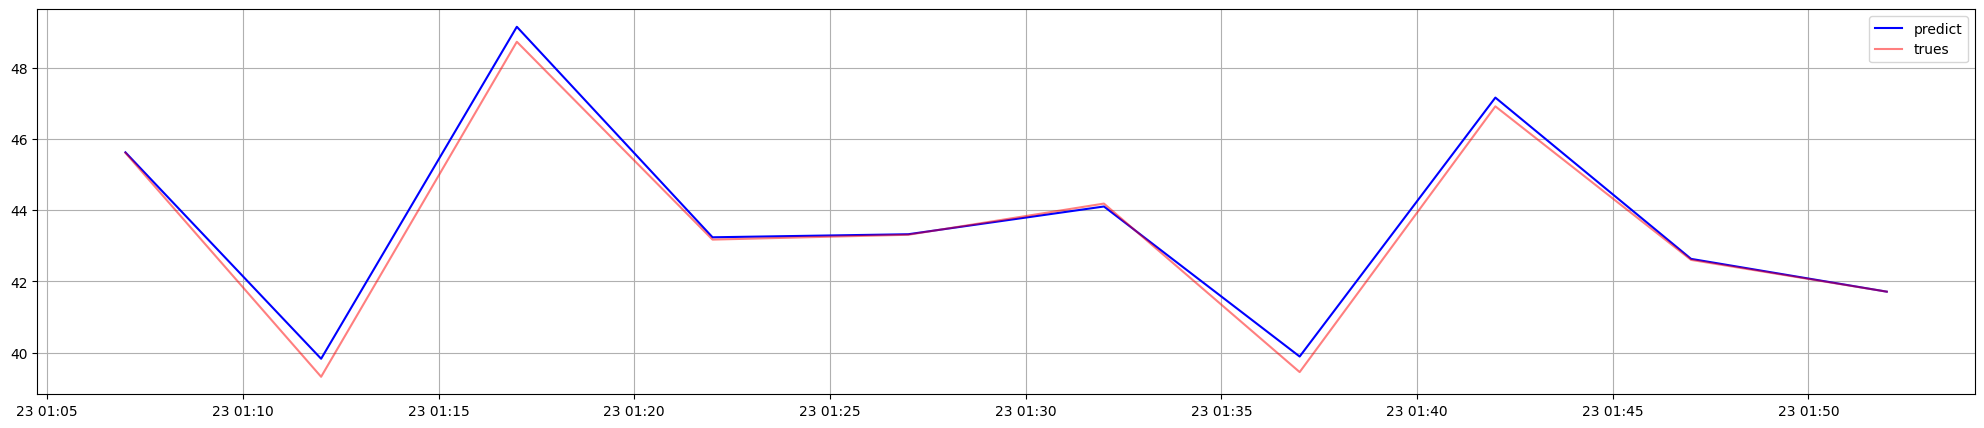

In [50]:
fig, ax = plt.subplots(1,1,figsize=(25,5))
ax.plot(infer_result['predict'].iloc[:10], color='blue', label='predict')
ax.plot(infer_result['trues'].iloc[:10], color='red', ls='-', alpha = 0.5, label='trues')
ax.legend()
ax.grid()
plt.show()


#### [stock price](https://www.kaggle.com/code/arezalo/lstm-stock-price-predition-by-pytorch)

In [ ]:
import torch
import torch.nn as nn
import random

<img src="https://miro.medium.com/v2/resize:fit:1400/1*bDANsXS4eqiLBX_iS1NHjQ.jpeg">

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, inputs):
        context_vector = self.encoder(inputs)
        outputs = self.decoder(context_vector)
        return outputs

<img src="https://miro.medium.com/v2/resize:fit:786/format:webp/1*UTlM-lb4156iwVBqgupLlw.jpeg">

<img src="https://miro.medium.com/v2/resize:fit:786/format:webp/1*fYw_890Nw7lCHNV8mFep9g.jpeg">

In [ ]:
# A more detailed recurrent encoder & decoder seq2seq model:

class Encoder(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        # Takes 1 time series value in this example, to hidden size
        self.rnn = nn.RNN(1, hidden_size)
        
    def forward(self, encoder_inputs):
        # NOTE: encoder_inputs looks like: 
        # [..., X_t-4, X_t-3, X_t-2, X_t-1, X_t]
        
        # We let Pytorch handle the rollout behind-the-scenes, 
        # so just feed in the whole encoder sequence.
        # And all we need is the final hidden vector as Z
        outputs, hidden = self.rnn(encoder_inputs)
        
        return outputs, hidden



In [ ]:
class Decoder(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        # Also takes 1 time series value
        self.rnn = nn.RNN(1, hidden_size)
        # The output layer transforms the latent representation 
        # back to a single prediction
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, initial_input, encoder_outputs, hidden, targets, 
                teacher_force_probability):
        # NOTE:
        # initial_input is X_t
        # hidden is Z
        # targets looks like: [X_t+1, X_t+2, X_t+3, ...]
        # encoder_outputs are not used, but will be for attention later
        
        decoder_sequence_length = len(targets)

        # Store decoder outputs
        outputs = [None for _ in range(decoder_sequence_length)]
        
        input_at_t = initial_input
        
        # Here we have to roll out the decoder sequence ourselves because of 
        # sometimes teacher forcing
        for t in range(decoder_sequence_length):            
            output, hidden = self.rnn(input_at_t, hidden)
            outputs[t] = self.out(output)
            
            # Set-up input for next timestep
            teacher_force = random.random() < teacher_force_probability
            # The next timestep's input will either be this timestep's 
            # target or output
            input_at_t = targets[t] if teacher_force else outputs[t]

        return outputs

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, lr):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

        self.optimizer = torch.optim.Adam(self.parameters(), lr)
        # The best loss function to use depends on the problem.
        # We will see a different loss function later for probabilistic
        # forecasting
        self.loss_function = nn.L1Loss()
    
    def forward(self, encoder_inputs, targets, teacher_force_probability):
        encoder_outputs, hidden = self.encoder(encoder_inputs)
        outputs = self.decoder(encoder_inputs[-1], encoder_outputs,
                               hidden, targets, teacher_force_probability)
        return outputs

    def compute_loss(self, outputs, targets):
        loss = self.loss_function(outputs, targets)
        return loss
    
    def optimize(self, outputs, targets):
        self.optimizer.zero_grad()
        loss = self.compute_loss(outputs, targets)
        loss.backward()
        self.optimizer.step()

In [ ]:
##
hidden_size = 256
lr = 0.03

seq2seq = Seq2Seq(Encoder(hidden_size), Decoder(hidden_size), lr)

[AD-AE](https://www.kaggle.com/code/lkskrk/time-series-anomaly-detection-with-autoencoders)